## I. Loading and Understanding the Data

In [1]:
import pandas as pd
path = 'spam_ham_txt.csv'

# Specify the encoding
spam_ham = pd.read_csv(path, encoding='ISO-8859-1') 

In [2]:
# Preview shape of dataset
spam_ham.shape

(7017, 2)

In [3]:
# Preview dataset
spam_ham.head()

,label,message
0,1,"A new and ""Green"" township will be rising in t..."
1,1,New OFFICE space for sale in Ortigas Avenue ne...
2,1,Celebrate the season of love with a sweet stay...
3,1,Shangri-La Updates:\n\nRISEmakati\n\n-One-of-a...
4,1,"Co in Makati needs Software Java Developer, kn..."


In [4]:
# Preview No. of spam (1) and hams (0)
spam_ham.label.value_counts()

label
0    4716
1    2301
Name: count, dtype: int64

In [5]:
# Print Data Frame Summary 
spam_ham.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    7017 non-null   int64 
 1   message  7017 non-null   object
dtypes: int64(1), object(1)
memory usage: 109.8+ KB


In [6]:
# Check null rows
spam_ham.isnull().sum()

label      0
message    0
dtype: int64

## II. Data Preprocessing

In [7]:
import re
import string
import py3langid as langid
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus.reader.wordnet import NOUN, VERB, ADJ, ADV

# English stopwords
english_stopwords = set(stopwords.words('english'))

# Tagalog stopwords (expandable)
tagalog_stopwords = set([
    'ang', 'sa', 'ng', 'mga', 'na', 'ay', 'at', 'ito', 'ko', 'ni', 'si', 'kay',
    'rin', 'din', 'pa', 'ba', 'may', 'wala', 'kung', 'para', 'pero', 'habang',
    'lahat', 'kasi', 'dahil', 'pati', 'naman', 'isang', 'akin', 'kami', 'kayo',
    'sila', 'tayo', 'natin', 'namin', 'nila', 'niya', 'siya', 'ako', 'ikaw',
    'eh', 'o', 'nga', 'lang', 'hindi', 'oo', 'huwag'
])

# Combined stopwords for Taglish
combined_stopwords = english_stopwords.union(tagalog_stopwords)

lemmatizer = WordNetLemmatizer()

In [8]:
# Convert NLTK POS tag to WordNet format
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return ADJ
    elif tag.startswith('V'):
        return VERB
    elif tag.startswith('N'):
        return NOUN
    elif tag.startswith('R'):
        return ADV
    else:
        return NOUN

# Preprocessing function
def preprocess_text(text):
    # Detect language (optional, can be used to customize logic)
    language, _ = langid.classify(text)

    # Lowercase and basic cleanup
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)               # remove URLs
    text = re.sub(r'\d+', '', text)                                   # remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation

    # Tokenize and POS tag
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)

    # Lemmatize and remove stopwords
    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in tagged
        if word.isalpha() and word not in combined_stopwords
    ]
    return ' '.join(lemmatized)

# Example usage
text = "I will go to the market mamaya, baka may mga bilihin."
processed_text = preprocess_text(text)
print("Preprocessed:", processed_text)


Preprocessed: go market mamaya baka bilihin


In [9]:
# Apply function to dataset
spam_ham['message'] = spam_ham['message'].apply(preprocess_text)
spam_ham.head()

,label,message
0,1,new green township rise south maple grove firs...
1,1,new office space sale ortigas avenue near grov...
2,1,celebrate season love sweet staycation intimat...
3,1,shangrila update risemakati oneofakind residen...
4,1,co makati need software java developer knowled...


In [10]:
# Save it to a new CSV file for checking
spam_ham.to_csv('spam_ham_preprocessed.csv', index=False, encoding='ISO-8859-1')

## III. Data Visualization

### Class Distribution and Proportion

Class Distribution:
label
0    4716
1    2301
Name: count, dtype: int64


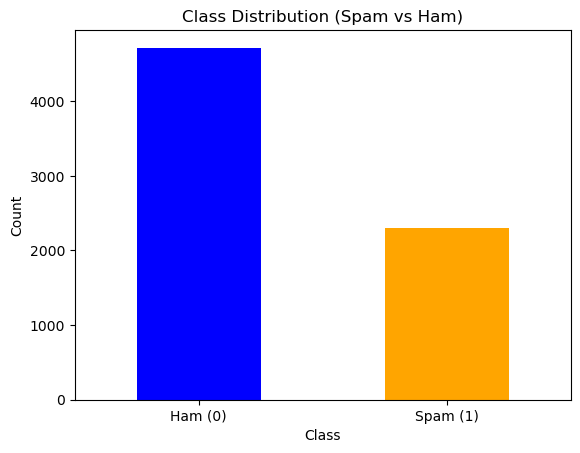

In [11]:
# Display the class distribution
class_distribution = spam_ham['label'].value_counts()

# Print the class distribution
print("Class Distribution:")
print(class_distribution)

# Optionally, visualize the distribution using a bar plot
import matplotlib.pyplot as plt

class_distribution.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution (Spam vs Ham)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Ham (0)', 'Spam (1)'], rotation=0)
plt.show()

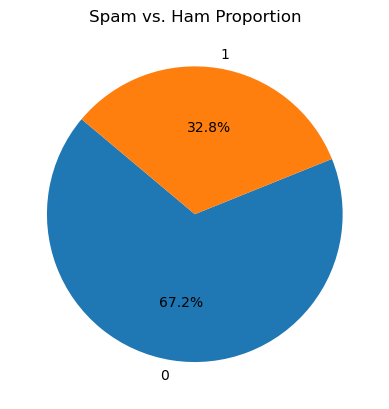

In [12]:
# Display Spam and Hap Proportion
spam_ratio = spam_ham['label'].value_counts(normalize=True)
plt.pie(spam_ratio, labels=spam_ratio.index, autopct='%1.1f%%', startangle=140)
plt.title('Spam vs. Ham Proportion')
plt.show()


### Message Length Distribution

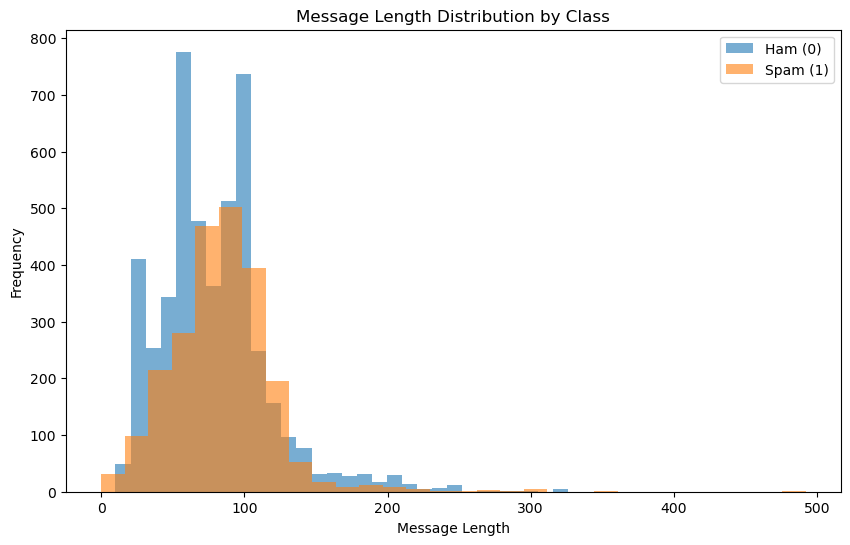

In [13]:
import matplotlib.pyplot as plt

# Add a new column for message length
spam_ham['message_length'] = spam_ham['message'].apply(len)

# Plot the distribution of message lengths by class
plt.figure(figsize=(10, 6))
for label, group in spam_ham.groupby('label'):
    plt.hist(
        group['message_length'],
        bins=30,
        alpha=0.6,
        label=f"{'Ham (0)' if label == 0 else 'Spam (1)'}",
    )

plt.title('Message Length Distribution by Class')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Word Cloud for All Messages

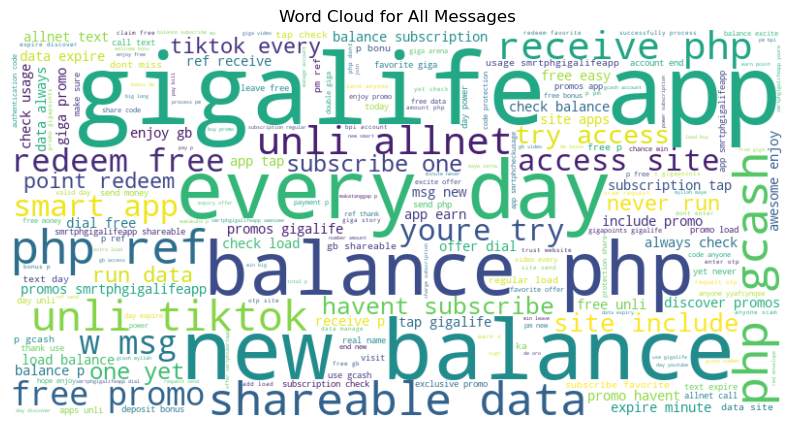

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all messages into a single string
all_text = " ".join(spam_ham['message'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Messages')
plt.show()

### Word Cloud for Spam and Ham Messages

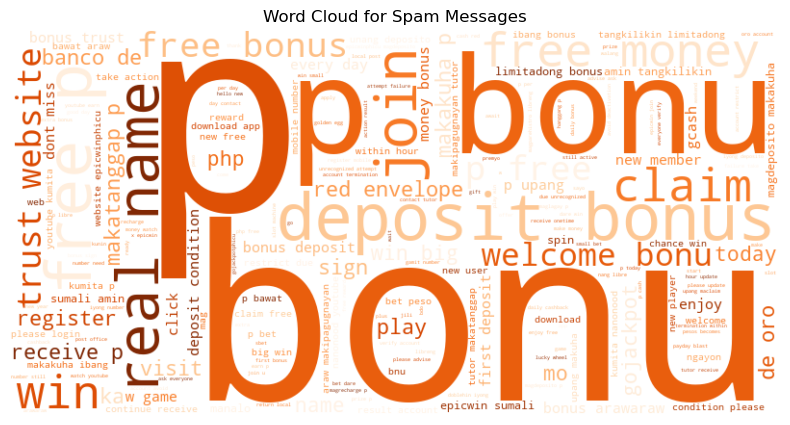

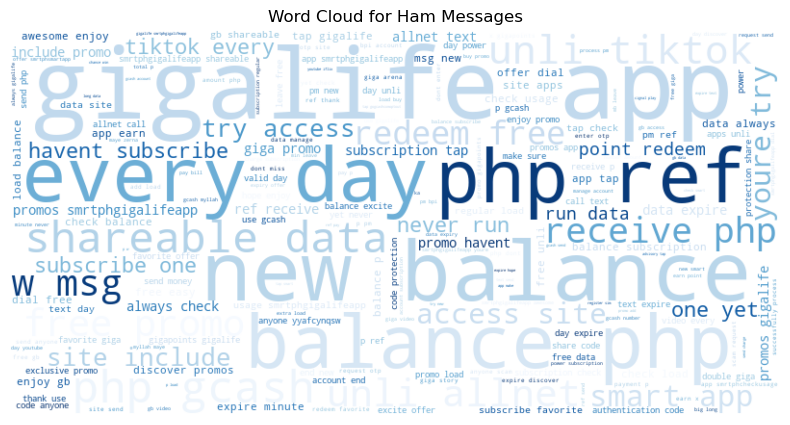

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds for spam and ham messages
spam_text = " ".join(spam_ham[spam_ham['label'] == 1]['message'])
ham_text = " ".join(spam_ham[spam_ham['label'] == 0]['message'])

# Spam Word Cloud
spam_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Oranges').generate(spam_text)
plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Messages')
plt.show()

# Ham Word Cloud
ham_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(ham_text)
plt.figure(figsize=(10, 5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Ham Messages')
plt.show()

### Top Words in Spam vs. Non-Spam Messages

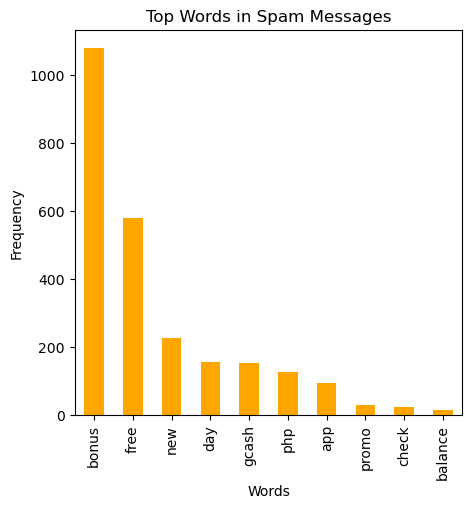

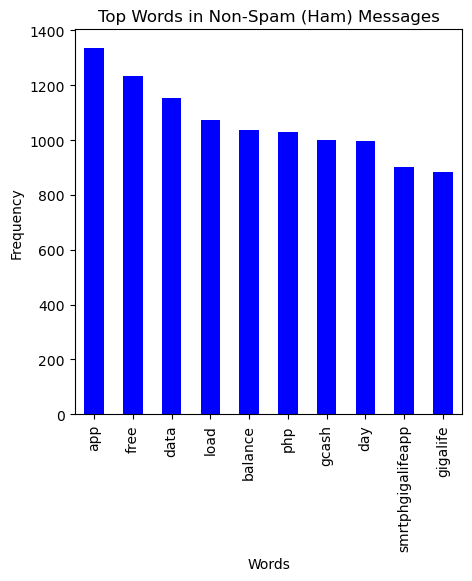

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Vectorize the messages
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(spam_ham['message'])

# Create a DataFrame for word frequencies
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
word_freq['label'] = spam_ham['label']

# Separate spam and ham word frequencies
spam_words = word_freq[word_freq['label'] == 1].drop(columns=['label']).sum().sort_values(ascending=False)
ham_words = word_freq[word_freq['label'] == 0].drop(columns=['label']).sum().sort_values(ascending=False)

# Plot top words for spam
plt.figure(figsize=(5, 5))
spam_words.head(10).plot(kind='bar', color='orange')
plt.title('Top Words in Spam Messages')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

# Plot top words for ham
plt.figure(figsize=(5, 5))
ham_words.head(10).plot(kind='bar', color='blue')
plt.title('Top Words in Non-Spam (Ham) Messages')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

## IV. Data Training and Testing


In [17]:
# Shuffle the rows randomly (since 0's and 1's are split)
spam_ham = spam_ham.sample(frac=1).reset_index(drop=True)
spam_ham.head()

,label,message,message_length
0,0,save free p giga promo load go new smart app s...,130
1,1,click phlinkeumyzrx cc member receive php free,46
2,0,payday sale there exclusive promo soon cant wa...,81
3,1,unionbank advisory protect account scammer ple...,79
4,0,p million freebie give away come gigaday get f...,103


In [18]:
# Import necessary libraries
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader

In [19]:
# Define a custom dataset class
class SpamDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }


In [20]:
# Encode labels
label_encoder = LabelEncoder()
spam_ham["label"] = label_encoder.fit_transform(spam_ham["label"])
spam_ham.head()

,label,message,message_length
0,0,save free p giga promo load go new smart app s...,130
1,1,click phlinkeumyzrx cc member receive php free,46
2,0,payday sale there exclusive promo soon cant wa...,81
3,1,unionbank advisory protect account scammer ple...,79
4,0,p million freebie give away come gigaday get f...,103


In [21]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    spam_ham["message"], spam_ham["label"], test_size=0.2, random_state=42
)

In [22]:
# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Create datasets
train_dataset = SpamDataset(X_train.tolist(), y_train.tolist(), tokenizer, max_length=128)
test_dataset = SpamDataset(X_test.tolist(), y_test.tolist(), tokenizer, max_length=128)


In [24]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",         # Directory to save the model checkpoints and outputs
    per_device_train_batch_size=8,  # Batch size per device (GPU) during training. (Used 8 for GTX 1650)
    gradient_accumulation_steps=4,  # Number of steps to accumulate gradients. This simulates a larger batch size
    fp16=True,                      # Use mixed precision training (float16) to save memory and speed up training
    eval_strategy="epoch",    # Evaluate the model after every epoch
    save_steps=100,                 # Save every 100 steps
    save_total_limit=3,             # Limit the number of saved checkpoints to the last 3
    save_strategy="epoch",          # Save the model checkpoint after every epoch
    logging_dir="./logs",           # Directory to save logs for tracking the training process
    num_train_epochs=2,             # Total number of training epochs
    logging_steps=20,               # How often to log the training process (in steps)
    load_best_model_at_end=True,    # Load the best model based on the evaluation metric after training finishes
    metric_for_best_model="accuracy",  # Use accuracy to determine the best model
    greater_is_better=True,            # Specify that higher accuracy is better when determining the best model
    seed=42,                           # Random seed for reproducibility
    do_train=True,                     # Enable training
    do_eval=True,                      # Enable evaluation
    report_to="tensorboard",           # Log the metrics to TensorBoard
)

In [25]:
# Define Evaluation Metrics
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"eval_accuracy": acc}


In [26]:
# Define Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

In [27]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.070300,0.060087,0.980057
1,0.030700,0.040164,0.990028


TrainOutput(global_step=350, training_loss=0.08346901938319207, metrics={'train_runtime': 2045.2034, 'train_samples_per_second': 5.489, 'train_steps_per_second': 0.171, 'total_flos': 371173651034112.0, 'train_loss': 0.08346901938319207, 'epoch': 1.9971509971509973})

In [28]:
# Save the model and tokenizer
model.save_pretrained("./distilbert_spam_model")
tokenizer.save_pretrained("./distilbert_spam_model")

('./distilbert_spam_model\\tokenizer_config.json',
 './distilbert_spam_model\\special_tokens_map.json',
 './distilbert_spam_model\\vocab.txt',
 './distilbert_spam_model\\added_tokens.json')

## V. Results and Model Evaluation


In [29]:
# Evaluate the model
trainer.evaluate()

{'eval_accuracy': 0.99002849002849,
 'eval_loss': 0.04016369953751564,
 'eval_runtime': 75.6064,
 'eval_samples_per_second': 18.57,
 'eval_steps_per_second': 2.328,
 'epoch': 1.9971509971509973}

In [30]:
# Perform Predictions on Test Set
predictions = trainer.predict(test_dataset)

In [31]:
# Provide Classification Report
import numpy as np
from sklearn.metrics import classification_report

preds = np.argmax(predictions.predictions, axis=1)  
labels = predictions.label_ids  

print(classification_report(labels, preds, target_names=['Ham', 'Spam']))

              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       909
        Spam       0.99      0.98      0.99       495

    accuracy                           0.99      1404
   macro avg       0.99      0.99      0.99      1404
weighted avg       0.99      0.99      0.99      1404



In [32]:
from sklearn.metrics import roc_auc_score

# Get the predicted probabilities (for the positive class, typically "Spam")
probabilities = predictions.predictions[:, 1]  # for binary classification, use column 1 for "Spam"

# Get the true labels from the test set
true_labels = predictions.label_ids

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(true_labels, probabilities)

print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9993


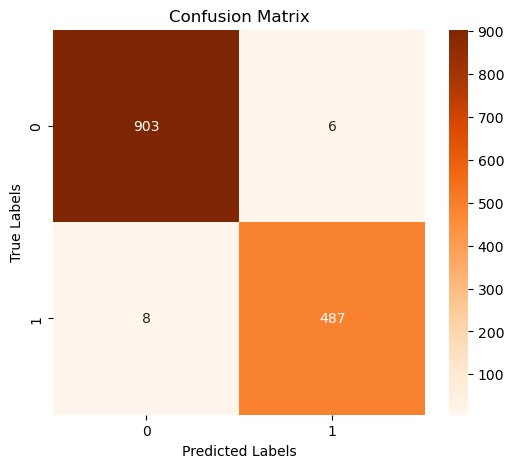

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert logits to predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Get the true labels from the test set
true_labels = predictions.label_ids

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


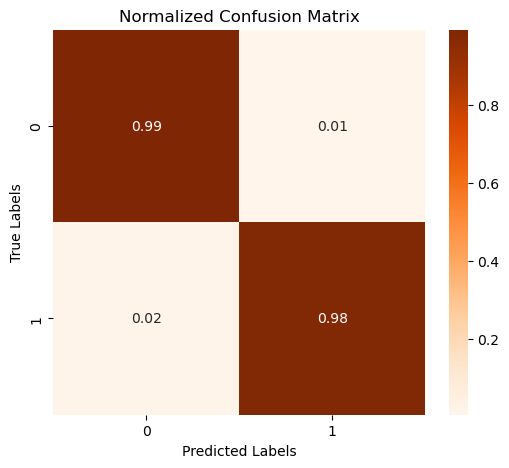

In [34]:
# Convert logits to predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Get the true labels from the test set
true_labels = predictions.label_ids

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Oranges", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()


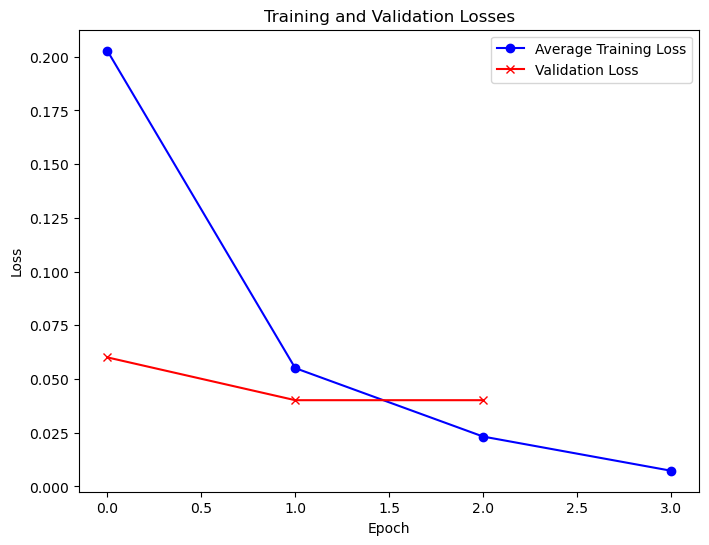

In [35]:
# Extract logs for training loss and validation loss
train_losses = []
eval_losses = []

# Extract logs from trainer state
log_history = trainer.state.log_history

# Store epoch-wise loss for training and validation
for log in log_history:
    if 'loss' in log:
        # Accumulate the training loss for each step within an epoch
        train_losses.append(log['loss'])
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])

# Compute average training loss per epoch
epoch_train_losses = [sum(train_losses[i:i+len(train_losses)//len(eval_losses)]) / (len(train_losses)//len(eval_losses)) for i in range(0, len(train_losses), len(train_losses)//len(eval_losses))]

# Plot the average training loss and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(epoch_train_losses, label="Average Training Loss", color="blue", marker="o")
plt.plot(eval_losses, label="Validation Loss", color="red", marker="x")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

plt.show()


### VI. Testing the Model with Sample Messages

In [36]:
def predict_spam(message):
    inputs = tokenizer(message, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    label = "spam" if predicted_class == 1 else "ham"
    return label
    
example_messages = [
    "Congratulations! You've won a free ticket to the Bahamas. Call now to claim.",
    "Hey, are we still meeting for lunch today?",
    "Urgent! Your account has been compromised. Please reset your password immediately.",
    "Don't forget to bring the documents to the meeting tomorrow.",
    "You've been selected for a $1000 gift card. Click here to claim now!"
]
for msg in example_messages:
    prediction = predict_spam(msg)
    print(f"Message: \"{msg}\"\nPredicted Label: {prediction}\n")
    

Message: "Congratulations! You've won a free ticket to the Bahamas. Call now to claim."
Predicted Label: spam

Message: "Hey, are we still meeting for lunch today?"
Predicted Label: ham

Message: "Urgent! Your account has been compromised. Please reset your password immediately."
Predicted Label: ham

Message: "Don't forget to bring the documents to the meeting tomorrow."
Predicted Label: ham

Message: "You've been selected for a $1000 gift card. Click here to claim now!"
Predicted Label: spam



In [37]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# File: test_SpamDefender_ML_Model.ipynb


# Load the trained model and tokenizer
model_path = "./distilbert_spam_model"
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)

# Function to predict the label for a given text
def predict_label(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return predicted_class

# Test case for the sample text
sample_text = "Hi John! Sarah from work. How's the update report going?"
predicted_label = predict_label(sample_text)

# Output the result
print(f"Predicted label for '{sample_text}': {predicted_label}")

Predicted label for 'Hi John! Sarah from work. How's the update report going?': 0
